<a href="https://colab.research.google.com/github/AliKarimiENT/Hamshari-News-Classification/blob/main/Hamshahri_News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

install libraries 

In [ ]:
!pip install nltk
!pip install hazm
!pip install stopwords_guilannlp
!pip install -U -q PyDrive
!pip install tensorflow
!pip install -U numpy==1.21
!pip install keras
!pip install seaborn


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read data from dataset

In [3]:
corpus_path = '/content/drive/MyDrive/University Tehran /Hamshahri-Corpus.txt'
data = []
category = ''
categories = []
desc = ''
category_id = 0
with open(corpus_path,'r') as f:
  lines = f.readlines()
  for line in lines:
    if line is not '\n':
      if ".DID" in line:
        if category is not '' and desc is not '':
            data.append([desc,category,category_id])
        category = ''
        desc = ''
      elif ".Cat" in line :
        category = line.split()[1]
        if category not in categories :
            categories.append(category)
        category_id = categories.index(category)
      elif ".Date" not in line:
        desc = desc + line.strip('\n')



In [4]:
import csv

header = ['Text','Category','Category ID']
with open('/content/train.csv','w',encoding = 'UTF8',newline='') as file:
  writer = csv.writer(file)

  # write the header
  writer.writerow(header)

  # write the data
  writer.writerows(data)


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow

# Preprocessing
from hazm import *

In [6]:
df = pd.read_csv('/content/train.csv', encoding='utf-8')[0:13000]
df

,Text,Category,Category ID
0,جاودانگي در زندگي گروهي از طريق هنر نگاهي به ن...,adabh,0
1,رويدادهاي هنري جهان نمايشگاه هنر در خدمت ديكتا...,adabh,0
2,برديوار نگارخانه ها گالري گلستان: نمايشگاه طرح...,adabh,0
3,بازي را جدي بگيريم مطالعه اي مقدماتي پيرامون ن...,ejtem,1
4,تخته سياه و غباري كه سترده نمي شود... اشاره; ب...,elmfa,2
...,...,...,...
12995,خبرهاي تازه از فوتبال انگليس رايت ماندني شد، ك...,vrzsh,10
12996,عصاي كارگشا در پارك لاله نمايش عصا، عصاي كارگ...,adabh,0
12997,جهان پهلوان ناتمام ماند و او خود تمام شد عزت ...,adabh,0
12998,نمايش فراموش شده ولاديمير ناباكف در بيست وسوم ...,adabh,0


Use seaborn library and countplot function to show volume of items for each category

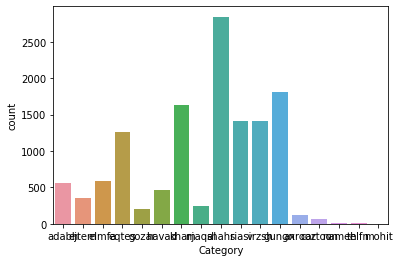

In [7]:
sns.countplot(x=df["Category"])
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.show()

In [8]:
# X is data that we set for train
X = df["Text"]

# Y is the label that we get from that
Y = df["Category"]

Encode label

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# convert categories to integers
Y = le.fit_transform(Y)
print(Y)

[0 0 0 ... 0 0 1]


Devide dataset to train and test parts

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)


Load stopwords list

In [11]:
path = '/content/drive/MyDrive/University Tehran /PersianStopWords.txt'
stopwords = []
with open(path,'r') as f:
    lines = f.readlines()
    for line in lines : 
      stopwords.append(line.strip('\n'))


Tokenize text

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from hazm import word_tokenize
from hazm import Stemmer

concept_words = []
words = []
for text in X_train:
    text_words = []
  # this array is list of words foreach sentence
    for word in word_tokenize(text):
      if word not in stopwords:
        text_words.append(word)
        words.append(word)
    concept_words.append(text_words)   

wordToIndex = {}
for i,word in enumerate(words) :
  wordToIndex[word] = i
      
max_words = 500

seq = []
for text in concept_words:
  wordIndexes = []
  for word in text:
    wordIndexes.append(wordToIndex[word])
  seq.append(wordIndexes)
print(seq)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The length of inputs must be equal

Use padding to set lengthes equaly 100



In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 100
# because we set padding = pre it added zeros before the word indexs
padded_docs = pad_sequences(seq,padding = 'pre',maxlen = max_len)
print(padded_docs)

[[2098065 2102717 2080773 ... 2097765 2104837 2104168]
 [      0       0       0 ... 2100075 2104685 2104101]
 [      0       0 2072334 ...    1026 2102936 2103754]
 ...
 [2103866 2103867 2103868 ... 2103963 2103964 2103965]
 [2104092 2104152 2104142 ... 2104178 2104179 2104180]
 [2104782 2104810 2104816 ... 2104879 2104880 2104881]]


Generate sequential model

> Use LSTM for classification



In [14]:
from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM,Dense,Input,Embedding

# number of features that we select for embeddings
embedding_vector_features = 30
model = Sequential()
model.add(Embedding(max_words,embedding_vector_features,input_length=max_len))

#Long Short Term Memory
model.add(LSTM(256)) 
# 256 means number of memory units

# add Dense to get classification output
# Dense layer is 1 dimentional
model.add(Dense(1,activation='sigmoid'))

model.compile(loss = 'binary_crossentropy',optimizer= 'adam',metrics =['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 30)           15000     
                                                                 
 lstm (LSTM)                 (None, 256)               293888    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 309,145
Trainable params: 309,145
Non-trainable params: 0
_________________________________________________________________
None


# Fit model 

In [15]:
model.fit(padded_docs,Y_train,batch_size=128,epochs=10,validation_split=0.2)
# validation split takes 20 percent of our train set for validation and improve parameters

Epoch 1/10
65/65 [==============================] - 9s 25ms/step - loss: -191.0087 - accuracy: 0.0102 - val_loss: -293.7220 - val_accuracy: 0.0082
Epoch 2/10
65/65 [==============================] - 1s 14ms/step - loss: -367.1585 - accuracy: 0.0096 - val_loss: -442.0417 - val_accuracy: 0.0082
Epoch 3/10
65/65 [==============================] - 1s 14ms/step - loss: -512.6078 - accuracy: 0.0096 - val_loss: -585.6457 - val_accuracy: 0.0082
Epoch 4/10
65/65 [==============================] - 1s 15ms/step - loss: -655.1261 - accuracy: 0.0096 - val_loss: -727.4905 - val_accuracy: 0.0082
Epoch 5/10
65/65 [==============================] - 1s 15ms/step - loss: -796.3428 - accuracy: 0.0096 - val_loss: -868.4452 - val_accuracy: 0.0082
Epoch 6/10
65/65 [==============================] - 1s 14ms/step - loss: -936.7689 - accuracy: 0.0096 - val_loss: -1008.9423 - val_accuracy: 0.0082
Epoch 7/10
65/65 [==============================] - 1s 15ms/step - loss: -1076.7717 - accuracy: 0.0096 - val_loss: -1